## Задание 1

In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import math
import sympy
from sympy import init_printing
from IPython.display import display
init_printing(use_latex='mathjax')

### Пункт 1

In [2]:
mean1 = [0, 0]
mean2 = [3, 3]
cov = [[1, 0], [0, 1]]
x1, y1 = np.random.multivariate_normal(mean1, cov, 500).T
x2, y2 = np.random.multivariate_normal(mean2, cov, 500).T

### Пункт 2

In [3]:
def quadratic_loss_optimization(samples, labels):
    labels = np.asarray(labels)
    np.reshape(labels, (labels.shape[0], 1))
    samples_t = samples.transpose();
    # pseudoinversion in case the matrix here is not invertible 
    return np.linalg.pinv((samples_t @ samples)) @ samples_t @ labels

### Пункт 3

Теперь по сгенерированным данным отобразим на графике оба класса (синий - "1", красный - "-1")

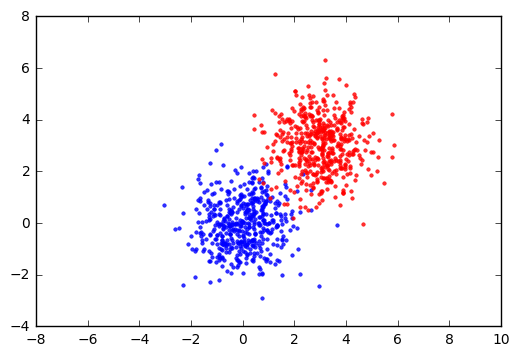

In [4]:
plt.plot(x1, y1, 'b.', x2, y2, 'r.', markersize=5, alpha=0.8)
plt.axis('equal')
plt.show()

### Пункт 4

In [5]:
x1_t = x1.reshape((x1.shape[0], 1))
y1_t = y1.reshape((y1.shape[0], 1))
x2_t = x2.reshape((x2.shape[0], 1))
y2_t = y2.reshape((y2.shape[0], 1))
samples_1 = np.hstack((x1_t, y1_t))
samples_2 = np.hstack((x2_t, y2_t))
labels_1 = np.ones((x1_t.shape[0], 1))
labels_2 = -np.ones((x2_t.shape[0], 1))
samples = np.vstack((samples_1, samples_2))
prepared_samples = np.hstack((samples, np.ones((samples.shape[0], 1))))
labels = np.vstack((labels_1, labels_2))
parameters = quadratic_loss_optimization(prepared_samples, labels)
coefs = parameters[:-1, 0]
shift = parameters[-1, 0]
print(coefs, shift)

[-0.28218586 -0.26498486] 0.822969118248


Простая функция определения класса

In [6]:
def classify(x, coefs, shift):
    if np.dot(x, coefs) + shift >= 0:
        return 1
    else:
        return -1
labeled_samples = np.apply_along_axis(classify, 1, samples, coefs, shift)

samples_x = samples[labeled_samples == 1]
samples_y = samples[labeled_samples == -1]

misses = samples[labeled_samples != labels[:, 0]].shape[0]

Теперь нарисуем на графике прямую, разбивающую точки на классы, и сами классы

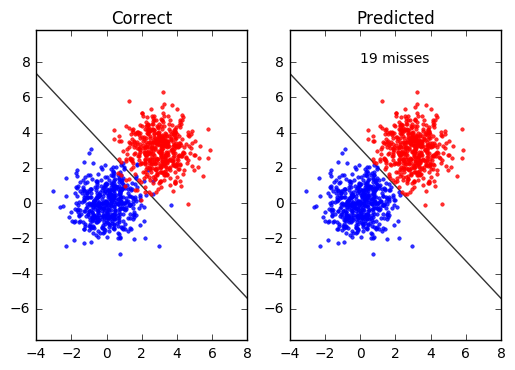

In [7]:
x = [x for x in range(-4, 9)]
y = [-(shift + coefs[0]*i)/coefs[1] for i in x]
plt.subplot(121)
plt.title('Correct')
plt.plot(x, y, 'k-', x1, y1, 'b.', x2, y2, 'r.', markersize=5, alpha=0.8)
plt.axis('equal')
plt.subplot(122)
plt.title('Predicted')
plt.plot(x, y, 'k-', samples_x[:, 0], samples_x[:, 1], 'b.', samples_y[:, 0], samples_y[:, 1],
                                                       'r.', markersize=5, alpha=0.8)
plt.text(0, 8, str(misses) + ' misses')
plt.axis('equal')
plt.show()

#### Отступление
Очевидно, что формулировка метода наименьших квадратов не подразумевает существования некоторого вектора-отступа $b$, который присутствует в нашей задаче. Тем не менее, эта задача сводится к методу наименьших квадратов добавлением в вектор признаков каждого элемента дополнительной компоненты $1$, которая по очевидным причинам не зависит от какого-либо элемента выборки и при скалярном произведении элемента на вектор признаков добавлять константу. В дальнейшем мы будем рассматривать уже модифицированную матрицу признаков и считать ассимптотику для неё.
#### Оценим сложность данного алгоритма
Прежде всего, стоит отметить, что для необратимых матриц $X^TX$ формула $w = (X^TX)^{-1}X^TY$ преобразуется в $w = (X^TX)^+X^TY$, где $M^+$ обозначает псевдообратную матрицу. Грубая оценка сложности алгоритма нахождения псевдообратной квадратной матрицы - $O(n^3)$.

Сложность умножения двух матриц определим, как $O(lmn)$ (для матриц $l \times m$ и $m \times n$).
Мы выполняем следующие операции: перемножение матриц $m \times n$ и $n \times m$, их псевдообращение, перемножение результата с матрицей $m \times n$, перемножение результата с матрицей $n \times 1$. Сложность в таком случае составляет $O(nm^2) + O(m^3) + O(nm^2) + O(nm) = O(nm^2) + O(m^3)$, где $n$ - число элементов в выборке, $m$ - число признаков (с единицей)

### Про похожесть на максимизацию правдоподобия
$\mathbb{P}\{y=1|x\} = \sigma(wx+b)$, где $\sigma(z) = \frac{1}{1 + \exp(-z)}$.

Тогда очевидно, что $\mathbb{P}\{y=-1|x\} = 1 - \mathbb{P}\{y=1|x\} = 1 - \frac{1}{1 + \exp(-(wx+b))} = \frac{1 + \exp(-(wx+b)) - 1}{1 + \exp(-(wx+b))} = \frac{\exp(-(wx+b))}{\exp(-(wx+b)) + 1} = \frac{1}{1 + \exp(wx+b)} = \sigma(-wx-b)$

Отсюда для $y \in \{-1, 1\} \; \forall y_i \; \mathbb{P}\{y_i=y \; | x\} = \sigma(y(wx+b))$

Тогда $ \arg\min_{w, b}~\sum_{i}~\ln(1 + \exp(-y_i(wx_i + b))) = \arg\min_{w, b}~\prod_{i}~(1 + \exp(-y_i(wx_i + b)) = \arg\max_{w, b}~\prod_{i}~\frac{1}{1 + \exp(-y_i(wx_i + b))} = \arg\max_{w, b}~\prod_{i}~\sigma(y_i(wx_i+b)) = \arg\max_{w, b}~\prod_{i}~\mathbb{P}\{y=y_i \; | x_i\}$. Таким образом, мы максимизируем по параметрам вероятность того, что для каждого элемента его предсказанный класс совпадает с действительным, что и является максимизацией правдоподобия

### Зависимость Q от M для различных функций потерь

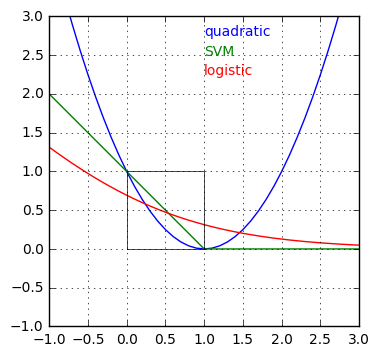

In [8]:
x = [x/10 for x in range(-100, 100)]
m = sympy.symbols('m')
f_quad = sympy.lambdify(m, (m-1)**2)
f_svm = sympy.lambdify(m, sympy.functions.Max(0, 1-m))
f_logistic = sympy.lambdify(m, sympy.log(1 + sympy.exp(-m)))
y_quad = [f_quad(i) for i in x]
y_svm = [f_svm(i) for i in x]
y_logistic = [f_logistic(i) for i in x]

x_box = [0, 1, 1, 0, 0]
y_box = [0, 0, 1, 1, 0]
plt.hold(True)
plt.plot(x, y_quad, 'b-', x, y_svm, 'g-', x, y_logistic, 'r-')
plt.plot(x_box, y_box, 'k-', linewidth=0.5)
plt.hold(False)
plt.axis([-1, 3, -1, 3])
plt.grid()
plt.axes().set_aspect('equal', adjustable='box')
plt.text(1.0, 2.75, 'quadratic', color='blue')
plt.text(1.0, 2.5, 'SVM', color='green')
plt.text(1.0, 2.25, 'logistic', color='red')
plt.show()

## Градиентный спуск для функции нескольких переменных
В качестве варианта реализации для простоты был выбран градиентный спуск с постоянным шагом

In [9]:
def gradient_descent(symbols, func, start, step=0.01, threshold=0.00001, points_log = None, steps_max_number=-1):
    current_location = np.asfarray(start)
    # existing numpy.ndarray objects are not copied by default
    if current_location is start:
        current_location = start.copy()
    step_number = 0
    while step_number != steps_max_number:
        if points_log != None:
            points_log.append(current_location.copy())
        gradient = np.asarray([func.diff(symbol).eval(current_location.tolist()) for symbol in symbols], dtype='float64')
        gradient *= step
        current_location -= gradient
        if math.sqrt(np.dot(gradient, gradient)) < threshold:
            break
        step_number += 1
    if points_log != None:
        points_log.append(current_location)
    return current_location
    
step = 0.02
start = [5.0, 5.0] # shoud be random
symbols = sympy.symbols('x0:2')
f = sympy.poly(2*(symbols[0] - 3)**2 + 5*(symbols[1]+1)**2 + 3)
print('running...')
log = []
result = gradient_descent(symbols, f, start, step, points_log=log)
print('finished at point', result, 'after', len(log), 'steps with value', f.eval(result.tolist()))

running...
finished at point [ 3.00010666 -1.        ] after 119 steps with value 3.00000002275188


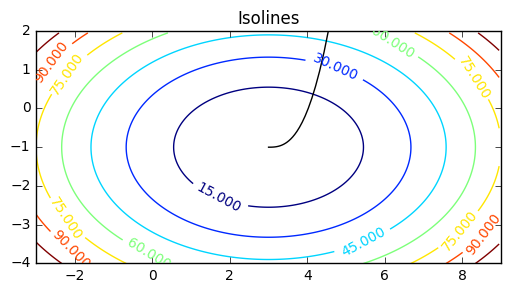

In [10]:
x = np.arange(-3, 9, 0.05)
y = np.arange(-4, 2, 0.05)
xgrid, ygrid = np.meshgrid(x, y)
eval_func = np.vectorize(lambda x, y: f.eval((x, y)))
zgrid = eval_func(xgrid, ygrid)
plt.hold(True)
CS = plt.contour(xgrid, ygrid, zgrid)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Isolines')
x = [p[0] for p in log]
y = [p[1] for p in log]
plt.plot(x, y, 'k-')
plt.axis([-3, 9, -4, 2])
plt.axes().set_aspect('equal', adjustable='box')
plt.hold(False)
plt.show()

Было выбрано максимальное значение $\lambda$, с которым алгоритм сходится

#### Тест на функции Розенброка:

running...
finished at point [ 1.12291607  1.26139738] after 49151 steps with value 0.0151292339338909


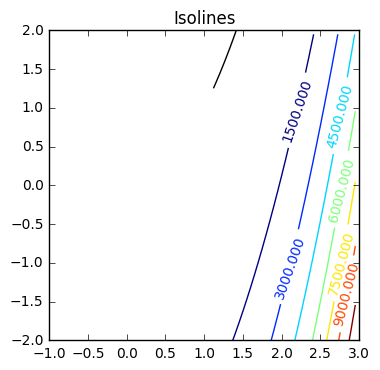

In [11]:
step = 0.0001
start = [2.0, 2.0] # shoud be random
x, y = sympy.symbols('x0:2')
f = sympy.poly((1-x)**2 + 100*(y - x**2)**2)
print('running...')
log = []
result = gradient_descent([x, y], f, start, step, points_log=log, steps_max_number = 100000)
print('finished at point', result, 'after', len(log), 'steps with value', f.eval(result.tolist()))

x = np.arange(-1, 3, 0.05)
y = np.arange(-2, 2, 0.05)
xgrid, ygrid = np.meshgrid(x, y)
eval_func = np.vectorize(lambda x, y: f.eval((x, y)))
zgrid = eval_func(xgrid, ygrid)
plt.hold(True)
CS = plt.contour(xgrid, ygrid, zgrid)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Isolines')
x = [p[0] for p in log]
y = [p[1] for p in log]
plt.plot(x, y, 'k-')
plt.axis([-1, 3, -2, 2])
plt.axes().set_aspect('equal', adjustable='box')
plt.hold(False)
plt.show()

Очевидные из запуска алгоритма пробллемы: при относительно больших $\lambda$ алгоритм расходится, а на множестве сходимости этот шаг очень мал, что в сочетании с тем, что алгоритм зачастую попадает в "овраг" с очень маленькими значениями градиента даёт очень низкую скорость сходимости. Из-за этого алгоритм не способен завершить работу за сколь-либо адекватное время. Например, в данном случае мы ограничиваем его 100000 итерациями.

Решается это изменением логики шага. Например, можно использовать метод наискорейшего спуска, для которого можно проводить очень быстрые одномерные оптимизации, не зависящие от нормы градиента

#### Протестируем градиентный спуск на начальном наборе точек:

In [12]:
symbols = np.asarray(sympy.symbols('x,y,b'))
f = sympy.poly(symbols[0])
for sample in enumerate(prepared_samples):
    f += (np.dot(sample[1], symbols) - labels[sample[0]])**2
f -= symbols[0]
f = f.expand()
f *= 1/prepared_samples.shape[0]
simple_log = []
result = gradient_descent(symbols, f, [5, 5, 5], points_log=simple_log)

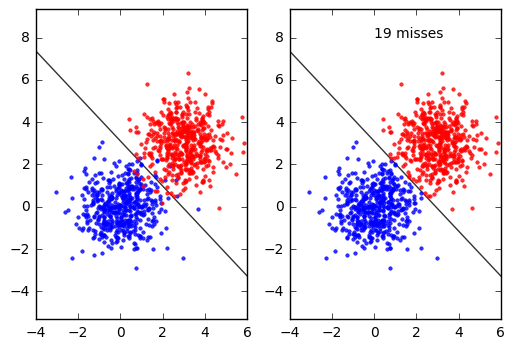

In [13]:
labeled_samples = np.apply_along_axis(classify, 1, samples, result[:2], result[2])
misses = samples[labeled_samples != labels[:, 0]].shape[0]

samples_x = samples[labeled_samples == 1]
samples_y = samples[labeled_samples == -1]

x = [x for x in range(-4, 7)]
y = [-(shift + coefs[0]*i)/coefs[1] for i in x]
plt.subplot(121)
plt.title('Correct')
plt.plot(x, y, 'k-', x1, y1, 'b.', x2, y2, 'r.', markersize=5, alpha=0.8)
plt.axis('equal')
plt.subplot(122)
plt.title('Predicted')
plt.plot(x, y, 'k-', samples_x[:, 0], samples_x[:, 1], 'b.', samples_y[:, 0], samples_y[:, 1],
                                                       'r.', markersize=5, alpha=0.8)
plt.text(0, 8, str(misses) + ' misses')
plt.axis('equal')
plt.show()

Очевидно, что ответ, полученный методом градиентного спуска для квадратичной функции потерь, будет очень близок к аналитическому решению,так как полином второй степени не имеет локальных минимумов, не совпадающих с глобальным, а его градиент не имеет резких перепадов и его норма близка к нулю только в окрестности глобального минимума.

### Метод наискорейшего спуска
#### Одномерная оптимизация (просто в лоб):

In [14]:
def dumb_descent_1d(symbols, func, start, direction, step=0.01, threshold=0.00001, points_log=None):  
    direction = np.asarray(direction, dtype='float').copy()
    direction *= 1.0/math.sqrt(np.dot(direction, direction))
    current_location = np.asfarray(start)
    if current_location is start:
        current_location = start.copy()
    
    while True:
        if points_log != None:
            points_log.append(current_location.copy())
        gradient = np.asarray([func.diff(symbol).eval(current_location.tolist()) for symbol in symbols], dtype='float64')
        diff = np.dot(gradient, direction)
        current_location -= direction * diff * step
        if abs(diff * step) < threshold:
            break
    if points_log != None:
        points_log.append(current_location)
    return current_location

#### Одномерная оптимизация квадратичной функции потерь по направлению:

In [49]:
def quadratic_descent_1d(symbols, func, start, direction, step=0.01, threshold=0.00001, points_log=None):
    direction = np.asarray(direction, dtype='float').copy()
    direction *= 1.0/math.sqrt(np.dot(direction, direction))
    x = sympy.symbols('x')
    expr = func.as_expr()
    for symbol, coeff in zip(symbols, direction):
        expr = expr.subs(symbol, x*coeff)
    minimum = -expr.coeff(x)/2/expr.coeff(x**2)
    # TODO: that`s wrong
    current_location = np.vectorize(lambda symbol, coeff: symbol*coeff)(direction, minimum)
#     print(current_location)
    if points_log != None:
        points_log.append(current_location)
    return current_location

#### Наискорейший спуск:

In [50]:
def steepest_descent(symbols, func, start, step=0.01, threshold=0.00001, points_log=None, steps_max_number=-1):
    current_location = np.asfarray(start)
    if current_location is start:
        current_location = start.copy()
    current_step_number = 0
    while current_step_number != steps_max_number:
        if points_log != None:
            points_log.append(current_location.copy())
        gradient = np.asarray([func.diff(symbol).eval(current_location.tolist()) for symbol in symbols], dtype='float64')
        old_location = current_location.copy()
        current_location = quadratic_descent_1d(symbols, func, old_location, gradient, step, threshold, points_log)
        diff = current_location - old_location
        if math.sqrt(np.dot(diff, diff)) < threshold:
            break
        current_step_number += 1
    if points_log != None:
        points_log.append(current_location)
    return current_location

In [51]:
step = 0.02
start = [5.0, 5.0] # shoud be random
symbols = sympy.symbols('x0:2')
f = sympy.poly(2*(symbols[0] - 3)**2 + 5*(symbols[1]+1)**2 + 3)
print('running...')
log = []
result = steepest_descent(symbols, f, start, step, points_log=log, steps_max_number=100)
print('finished at point', result, 'after', len(log), 'steps with value', f.eval(result.tolist()))

running...
finished at point [3.19148936170213 -0.425531914893619] after 201 steps with value 4.72340425531914


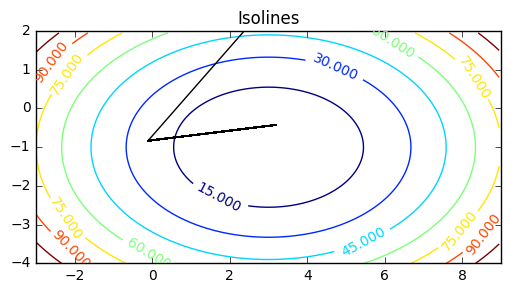

In [52]:
x = np.arange(-3, 9, 0.05)
y = np.arange(-4, 2, 0.05)
xgrid, ygrid = np.meshgrid(x, y)
eval_func = np.vectorize(lambda x, y: f.eval((x, y)))
zgrid = eval_func(xgrid, ygrid)
plt.hold(True)
CS = plt.contour(xgrid, ygrid, zgrid)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Isolines')
x = [p[0] for p in log]
y = [p[1] for p in log]
plt.plot(x, y, 'k-')
plt.axis([-3, 9, -4, 2])
plt.axes().set_aspect('equal', adjustable='box')
plt.hold(False)
plt.show()

In [16]:
symbols = np.asarray(sympy.symbols('x,y,b'))
f = sympy.poly(symbols[0])
for sample in enumerate(prepared_samples):
    f += (np.dot(sample[1], symbols) - labels[sample[0]])**2
f -= symbols[0]
f = f.expand()
f *= 1/prepared_samples.shape[0]
steepest_log = []
result = steepest_descent(symbols, f, [5, 5, 5], points_log=steepest_log)

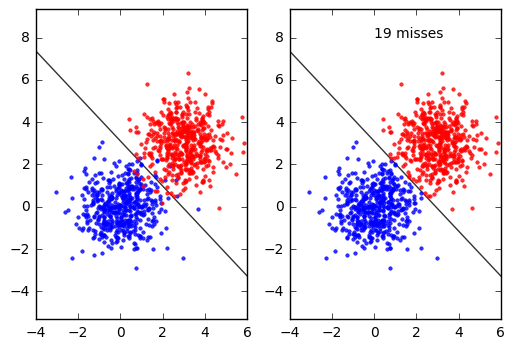

In [17]:
labeled_samples = np.apply_along_axis(classify, 1, samples, result[:2], result[2])
misses = samples[labeled_samples != labels[:, 0]].shape[0]

samples_x = samples[labeled_samples == 1]
samples_y = samples[labeled_samples == -1]

x = [x for x in range(-4, 7)]
y = [-(shift + coefs[0]*i)/coefs[1] for i in x]
plt.subplot(121)
plt.title('Correct')
plt.plot(x, y, 'k-', x1, y1, 'b.', x2, y2, 'r.', markersize=5, alpha=0.8)
plt.axis('equal')
plt.subplot(122)
plt.title('Predicted')
plt.plot(x, y, 'k-', samples_x[:, 0], samples_x[:, 1], 'b.', samples_y[:, 0], samples_y[:, 1],
                                                       'r.', markersize=5, alpha=0.8)
plt.text(0, 8, str(misses) + ' misses')
plt.axis('equal')
plt.show()

### Сравним теперь скорость сходимости обычного и наискорейшего спуска

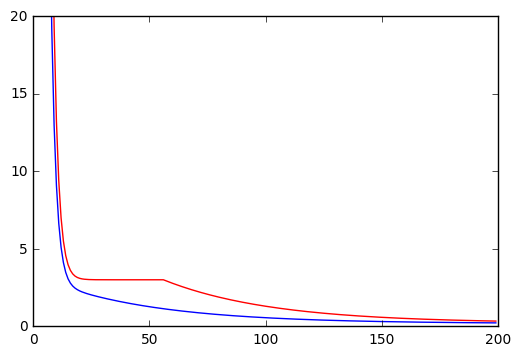

In [18]:
x = list(range(0, min(200, len(simple_log), len(steepest_log))))
y_simple = [f.eval(simple_log[i].tolist()) for i in x]
y_steepest = [f.eval(steepest_log[i].tolist()) for i in x]
plt.plot(x, y_simple, 'b-',
         x, y_steepest, 'r-')
plt.axis([0, 200, 0, 20])
plt.show()